In [1]:
%matplotlib inline

import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms
from copy import deepcopy
from utils import *
import seaborn as sns

torch.manual_seed(12345)
print(torch.__version__, torchvision.__version__)

%load_ext autoreload
%autoreload 2

/data/data/amenon-data/EthicalLLM/ethics/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.3.0+cu121 0.18.0+cu121


## Candidate Quantization functions

In [3]:
a = torch.rand(5, dtype=torch.float64)

levels = 16

print("Original tensor \n",a)

print("\nVanilla quantization \n",uniform_quantization(a, levels))

print("\n Log quantization \n",log_quantization(a))

print("\n K means quantization\n",kmeans_quantization(a, 3))

print("\n Stochastic rounding quantization\n",stochastic_rounding(a, levels))

print("\n Pruning quantization\n",add_sparsity(a, 0.5))

Original tensor 
 tensor([0.3199, 0.7562, 0.1792, 0.9981, 0.7452], dtype=torch.float64)

Vanilla quantization 
 tensor([0.3430, 0.7797, 0.1792, 0.9981, 0.7251], dtype=torch.float64)

 Log quantization 
 tensor([0.2500, 1.0000, 0.2500, 1.0000, 1.0000], dtype=torch.float64)

 K means quantization
 tensor([0.2496, 0.7507, 0.2496, 0.9981, 0.7507], dtype=torch.float64)

 Stochastic rounding quantization
 tensor([0.3430, 0.7797, 0.1792, 0.9981, 0.7797], dtype=torch.float64)

 Pruning quantization
 tensor([0.0000, 0.7562, 0.0000, 0.9981, 0.7452], dtype=torch.float64)


In [4]:
dst = datasets.CIFAR10("~/.torch", download=True)
tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])
tt = transforms.ToPILImage()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Running on %s" % device)

def label_to_onehot(target, num_classes=100):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

100%|███████████████████████████████████████████████████████████████| 170498071/170498071 [00:06<00:00, 27854561.46it/s]


Extracting /home/amenon/.torch/cifar-10-python.tar.gz to /home/amenon/.torch
Running on cuda


## Using LeNet() for the inverse attack. Chosen to ensure that you do not need a pretrained model to perform a good Deep Leakage from Gradients Inversion attack

In [6]:
def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, 100)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out


net = LeNet().to(device)
net.apply(weights_init)
criterion = cross_entropy_for_onehot

## Good seed with faster convergence, since DLG is prone to gradient spikes, which lead to divergence in the algorithm

In [8]:
model = torch.load("model.pth")
net = LeNet().to(device)
net.load_state_dict(model)

<All keys matched successfully>

GT label is 6. 
Onehot label is 6.


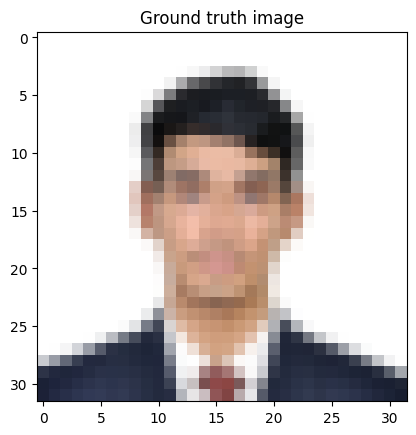

In [9]:
######### honest partipant #########
img_index = 25
gt_data = tp(dst[img_index][0]).to(device)

gt_data = tp(Image.open('images/me.jpg')).to(device)

gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=100)

plt.imshow(tt(gt_data[0].cpu()))
plt.title("Ground truth image")
print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())

# compute original gradient
out = net(gt_data)
y = criterion(out, gt_onehot_label)
dy_dx_ = torch.autograd.grad(y, net.parameters())

import torch.quantization as quant



In [10]:
def compute_history(dy_dx_, fun, gt_data, gt_onehot_label ):

    # Reinitialize the model
    model = torch.load("model.pth")
    net = LeNet().to(device)
    net.load_state_dict(model)
    criterion = cross_entropy_for_onehot

    
    # Quantize the gradients using compression function fun
    quantized_dy_dx = []
    for grad in deepcopy(dy_dx_):
        quantized_grad = fun(grad)
        quantized_dy_dx.append(quantized_grad)
    
    dy_dx = list((_.detach().clone() for _ in quantized_dy_dx))
    
    
    # share the gradients with other clients
    original_dy_dx = list((_.detach().clone() for _ in dy_dx))
    
    # generate dummy data and label
    dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
    dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)
    
    plt.imshow(tt(dummy_data[0].cpu()))
    plt.title("Dummy data")
    print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())
    
    optimizer = torch.optim.LBFGS([dummy_data, dummy_label] )
    
    MAX_ITER = 100
    history = []
    for iters in range(MAX_ITER):
        def closure():
            optimizer.zero_grad()
    
            pred = net(dummy_data)
            dummy_onehot_label = F.softmax(dummy_label, dim=-1)
            dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
            dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
    
            grad_diff = 0
            grad_count = 0
            for gx, gy in zip(dummy_dy_dx, original_dy_dx): # TODO: fix the variablas here
                grad_diff += ((gx - gy) ** 2).sum()
                grad_count += gx.nelement()
            # grad_diff = grad_diff / grad_count * 1000
            grad_diff.backward()
    
            return grad_diff
    
        optimizer.step(closure)
        if iters % 10 == 0:
            current_loss = closure()
            print(iters, "%.4f" % current_loss.item())
        history.append(tt(dummy_data[0].cpu()))

    return history


## Test the convergence of the DLG attack when using quantized or sparsified gradients 

Methods 
- Uniform Quantization using 120 levels (not that coarse)
- Stochastic Rounding with 240 levels (higher number of levels since it leads to higher information reduction empirically
- Sparsification with a 10% threshold

Analysis 
-  L1 loss over predicted and actual datapoint over the iterations
-  Final reconstructed image for qualitative analysis

Uniform Quantization
Dummy label is 66.
0 87.8346
10 1.4861
20 0.3897
30 0.3041
40 0.2835
50 0.2769
60 0.2740
70 0.2722
80 0.2712
90 0.2709


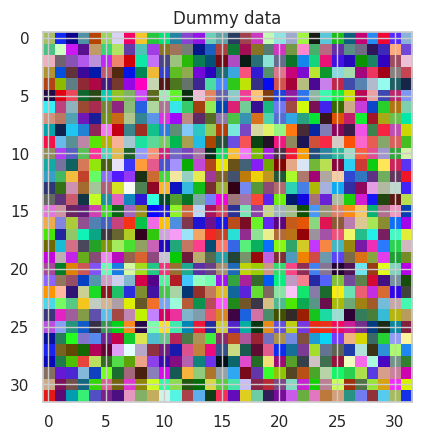

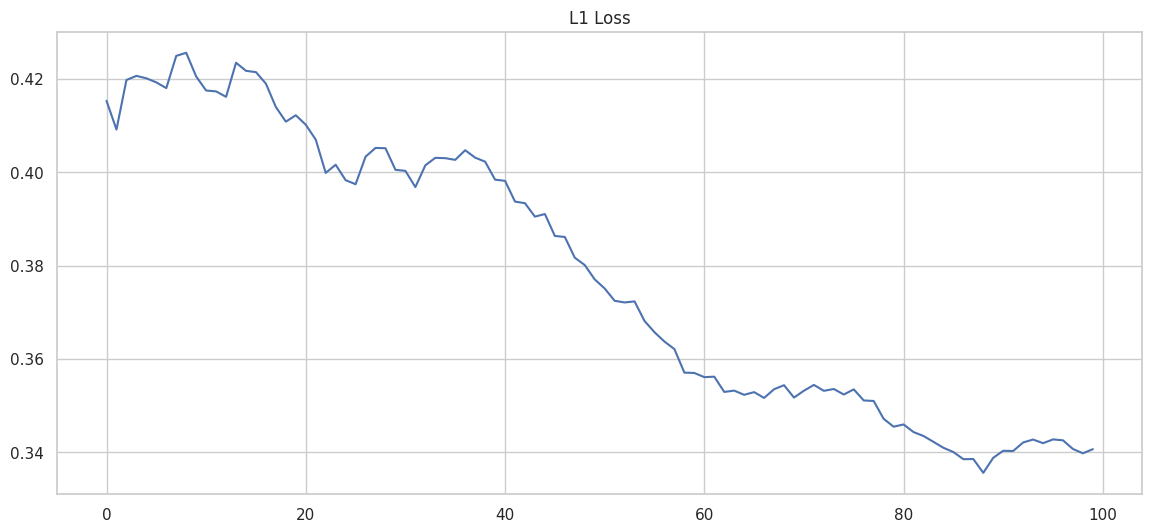

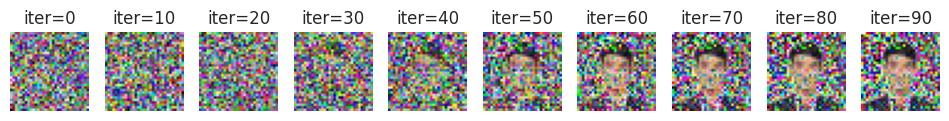

Stochastic Rounding
Dummy label is 39.
0 86.3665
10 1.1010
20 0.4452
30 0.3926
40 0.3825
50 0.3791
60 0.3777
70 0.3771
80 0.3767
90 0.3765


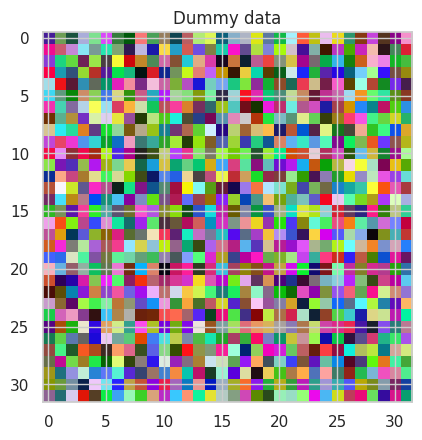

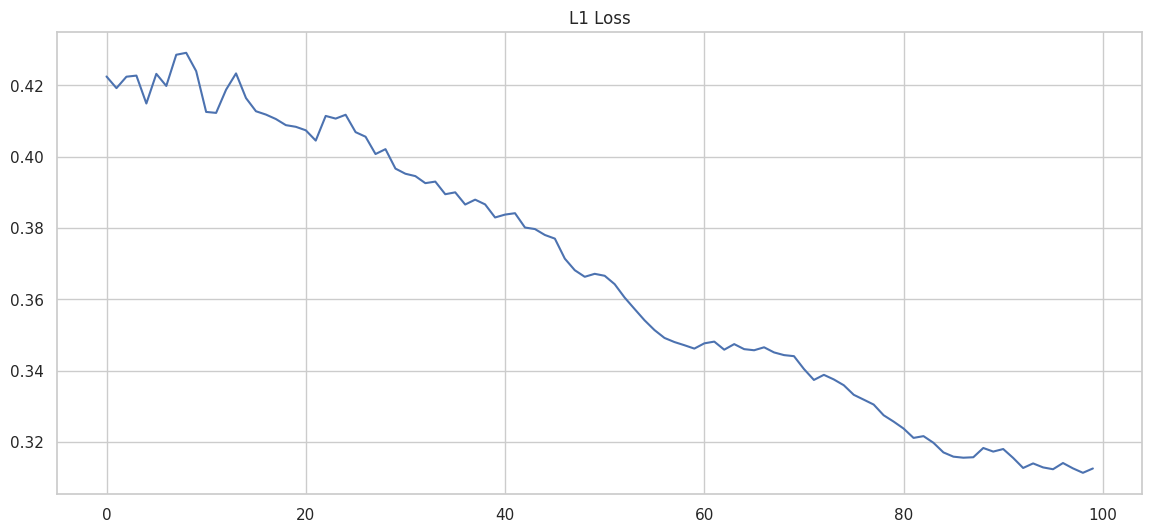

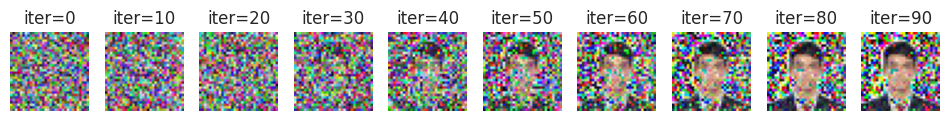

10% Sparsification
Dummy label is 63.
0 81.5677
10 2.0329
20 0.2477
30 0.0798
40 0.0444
50 0.0324
60 0.0280
70 0.0260
80 0.0250
90 0.0246


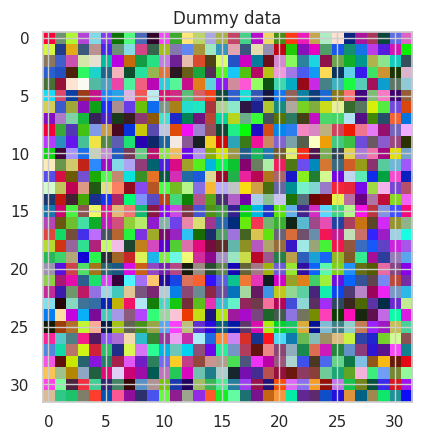

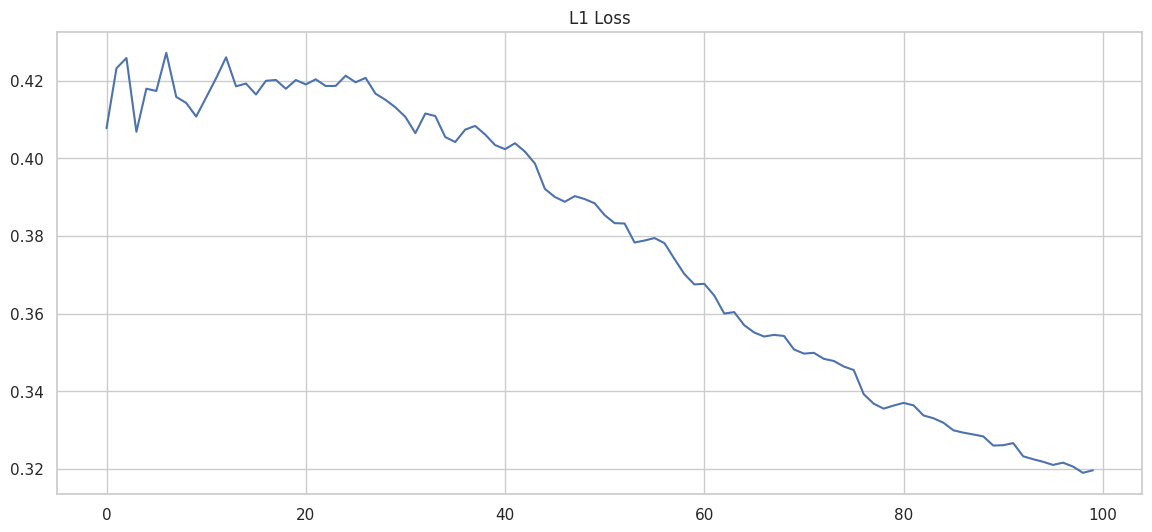

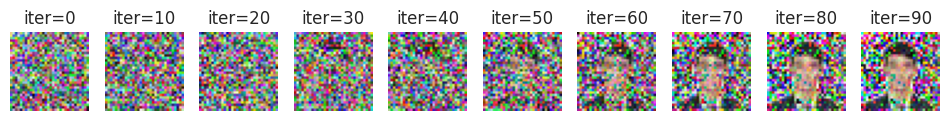

In [15]:
quant_history = {}

function_names = ['Uniform Quantization', 'Stochastic Rounding', '10% Sparsification']

for i, fun in enumerate([lambda x: uniform_quantization(x, 120) , \
            lambda x: stochastic_rounding(x,240), \
            lambda x: add_sparsity(x,0.1)]):

    print(function_names[i])
    history = compute_history(dy_dx_, fun, gt_data, gt_onehot_label )

    history_tensors = [tp(img).to(device) for img in history]
    # Convert ground truth image to tensor
    gt_tensor = gt_data[0].to(device)
    sns.set(style="whitegrid")
    
    plt.figure(figsize=(14, 6))
    # Calculate L2 loss
    l1_losses = []
    for img_tensor in history_tensors:
        l1_losses.append(torch.nn.L1Loss()(img_tensor, gt_tensor).item())
    
    # Print the total L2 loss
    sns.lineplot(x=range(len(l1_losses)), y=l1_losses)
    plt.title("L1 Loss")
    plt.show()

    plt.figure(figsize=(12, 8))
    
    for i in range(len(history)//10):
        plt.subplot(len(history)//100, 10, i + 1)
        plt.imshow(history[i * 10])
        plt.title("iter=%d" % (i * 10))
        plt.axis('off')

    plt.show()
